# Transmission Line Model

Based on Matlab code frω Brad Story

Brad's version is based on Sondhi and Schroeter (1987) and Story, Laukkanen, and Titze (2000).

### Imports

In [85]:
using Plots
using CSV
using DataFrames

### Parameters

In [86]:
area_function = fill(1, 44) # cross sectional area as a function of distance from glottis
length_function = fill(.4, 44) # length of each tublet in area function
cutoff = 45 # the hard walled tube to extend the vocal tract (only used for impedance studies and normally set to n+1)
max_frequency = 5000 # ceiling in frequency response

r = 408 # ratio of yielding wall resistance to mass
fw = 15 # mechanical resonance frequency of the wall
ft = 200 # lowest resonant frequency of the tract when closed on both ends 

q = 4.0 # correction for thermal conductivity and viscosity normally set to 4 rad/s
c = 35000.0 # speed of sound
ρ = 0.00114 # density of air

println("Parameters set")

Parameters set


### Preliminary Calculations

In [87]:
n_sections = length(area_function) # number of sections in area function
n_points = Int64(round(max_frequency/5)) # maximum points in frequency spectrum
delta_f = max_frequency/n_points
frequencies = [delta_f:delta_f:delta_f*n_points;] # the frequencies at which response and impedance are calculated
n_frequencies = length(frequencies) # number of frequencies at which ...
ω = (2*π) .* frequencies # TODO define the rest below
α = zeros(n_frequencies, 1) + im*(q*ω) 
α = sqrt.(α)
temp1 = r*ones(n_frequencies, 1) + im*(ω)
temp2 = zeros(n_frequencies, 1) + im*(ω)
den = temp1 .* temp2
temp1 = ((2*π*fw)^2)*ones(n_frequencies, 1) + im*zeros(n_frequencies, 1)
den = den + temp1
num = zeros(n_frequencies, 1) + im*ω*(2*π*ft)^2
β = (num ./ den) + α

print("Preliminary calculations complete")

Preliminary calculations complete

### Main Loop

In [88]:
# These are the ABCD matrices that make up the chain matrix for the vocal tract.
# They are based on electrical transmission line theory.

A = ones(n_points, 1);
C = zeros(n_points, 1);
B = zeros(n_points, 1);
D = ones(n_points, 1);

for k in 1:n_sections
# for k in 1:3
    # println("iteration ", k)

    temp1 = r*ones(n_frequencies, 1) + im*(ω)
    temp2 = β + (zeros(n_frequencies, 1) + im*ω)
    γ = sqrt.(temp1 ./ temp2)
    σ = γ .* temp2

    nA = cosh.((length_function[k]/c) * σ)
	temp1 = -ρ*c/area_function[k] * γ
	nB = temp1 .* sinh.( (length_function[k]/c) * σ)
	temp1 = ones(length(γ), 1) ./ γ
	temp2 = -area_function[k]/(ρ*c) * temp1
	nC = temp2 .* sinh.((length_function[k]/c) * σ)
	nD = nA

    M1 = [A B; C D]
    M2 = [nA nB; nC nD]

    # println("M1: ", M1)
    # println(size(M1))
    # println("M2: ", M2)
    # println(size(M2))

    # M1 = vcat([A B], [C D])
    # M2 = vcat([nA nB], [nC nD])

    A = M2[1:n_points, 1].*M1[1:n_points, 1] + M2[1:n_points, 2].*M1[n_points+1:end, 1]
    B = M2[1:n_points, 1].*M1[1:n_points, 2] + M2[1:n_points, 2].*M1[n_points+1:end, 2]
    C = M2[n_points+1:end, 1].*M1[1:n_points, 1] + M2[n_points+1:end, 2].*M1[n_points+1:end, 1]
    D = M2[n_points+1:end, 1].*M1[1:n_points, 2] + M2[n_points+1:end, 2].*M1[n_points+1:end, 2]

    # println("A: ",A)
    # println("B: ",B)
    
end
println("Finished loop")

Finished loop


### Final Calculations

In [89]:
R = 128 .* ρ*c/(9*π^2 * area_function[n_sections])    
L = 8 .* ρ*c/((3*π*c)*sqrt.(area_function[n_sections]*π)) 	
  
temp1 = zeros(n_points, 1) + im*R*L*ω
temp2 = R*ones(n_points, 1) + im*L*ω
Zrad = temp1 ./ temp2

temp1 = (Zrad .* D) - B
temp2 = A - (C .* Zrad)
z = temp1 ./ temp2
h = Zrad ./ temp2
f = frequencies

S = temp2 ./ temp1

h_alt = (-C .* B) ./ A+D

println("Calculations complete")

Calculations complete


### Plots

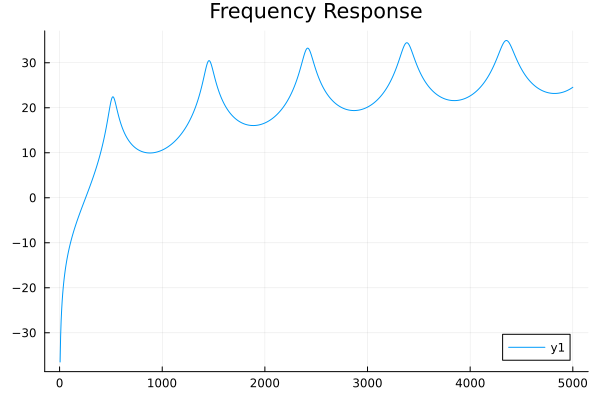

In [90]:
plot(f, 20 .* log10.(abs.(h)), title="Frequency Response")

MATLAB frequency response for comparison
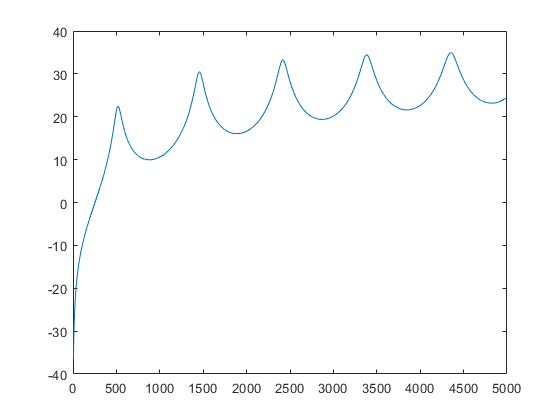

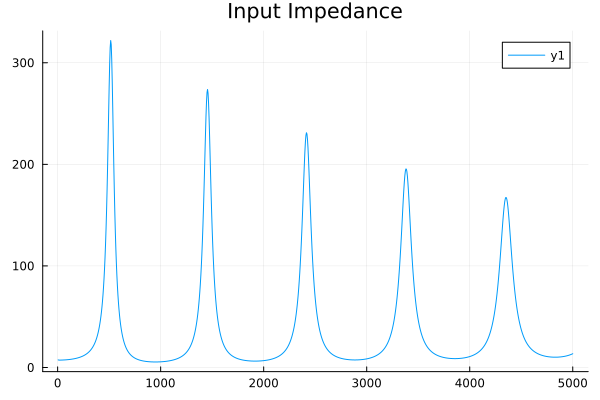

In [91]:
plot(f, real(z), title="Input Impedance")

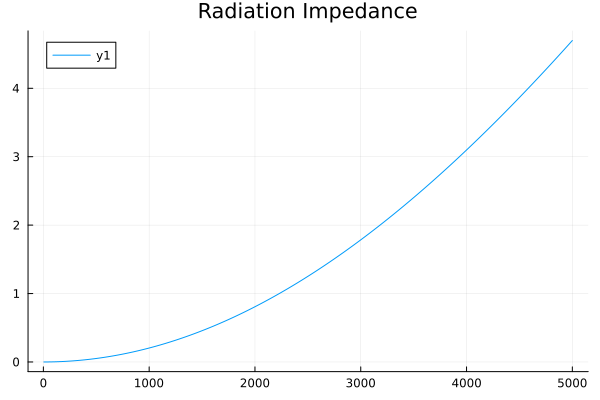

In [92]:
plot(f, real(Zrad), title="Radiation Impedance")

### Demonstrations from Fant
#### Russian vowels

In [93]:
include("../utils.jl")

find_peaks (generic function with 1 method)

In [94]:
# *** This is the electrical analogue area function from the book

# a
area = [
    5,
    5,
    5,
    5,
    6.5,
    8,
    8,
    8,
    8,
    8,
    8,
    8,
    8,
    6.5,
    5,
    4,
    3.2,
    1.6,
    2.6,
    2.6,
    2,
    1.6,
    1.3,
    1,
    0.65,
    0.65,
    0.65,
    1,
    1.6,
    2.6,
    4,
    1,
    1.3,
    1.6,
    2.6,
]

# Need to reverse the area function because Fant uses lips -> glottis
f, h, z, zrad = transmission_line_model(reverse(area), fill(.5,35))

([5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0  …  4955.0, 4960.0, 4965.0, 4970.0, 4975.0, 4980.0, 4985.0, 4990.0, 4995.0, 5000.0], ComplexF64[0.0005073182132673335 + 0.006928211425505209im; 0.0007061315328327635 + 0.013421526656371778im; … ; -5.502566529516354 - 1.9543093104860536im; -5.590442003366089 - 1.8826741544050467im;;], ComplexF64[3.719004064220676 + 0.1549342109849785im; 3.662141303426871 + 0.4826657404834413im; … ; 6.045220557695979 - 32.04296330708819im; 6.118794782354642 - 31.86328397854384im;;], ComplexF64[5.116305759477727e-6 + 0.00767031945423015im; 2.0465195721537435e-5 + 0.015340618432229917im; … ; 3.5359815213500037 + 5.306418026293012im; 3.5408832213144175 + 5.308460192648369im;;])

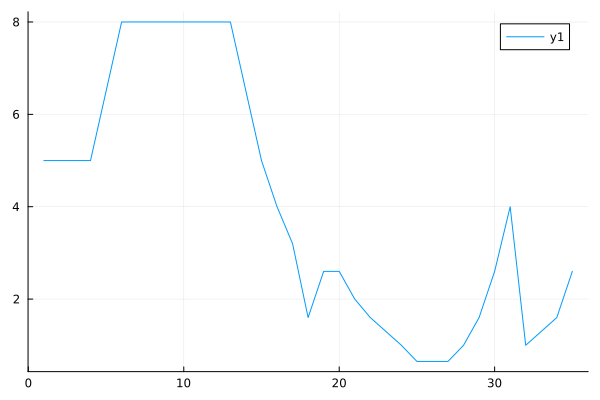

In [95]:
plot(area)

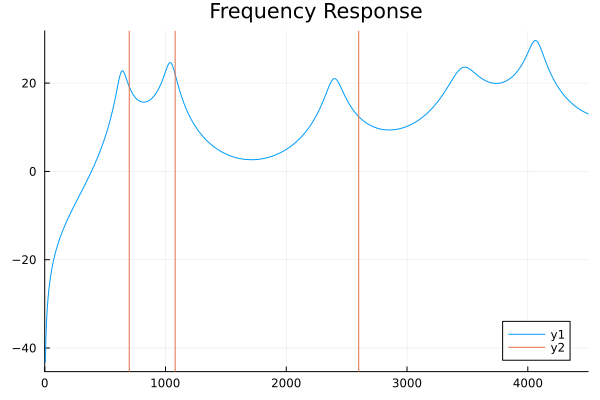

In [96]:
plot(f, 20 .* log10.(abs.(h)), title="Frequency Response", xlim=(0, 4500))
vline!([700, 1080, 2600])

In [97]:
# These are already reversed from Fant's
# so these are cross-sectional area as a function of distance from glottis

df = CSV.read("../matlab/fant_area_functions.txt", DataFrame, delim=',', header=false)

iy = tl_vocal_tract(Vector(df[1, :]), 0.375, "iy")
ei = tl_vocal_tract(Vector(df[2, :]), 0.375, "ei")
ah = tl_vocal_tract(Vector(df[3, :]), 0.3864, "ah")
oa = tl_vocal_tract(Vector(df[4, :]), 0.4205, "oa")
uu = tl_vocal_tract(Vector(df[5, :]), 0.4432, "uu")

tl_vocal_tract([2.0, 2.5, 2.7, 9.5, 9.4, 9.0, 8.5, 7.3, 5.8, 3.9  …  12.5, 12.3, 11.1, 6.0, 2.7, 1.0, 0.3, 0.15, 0.25, 0.8], 0.4432, "uu")

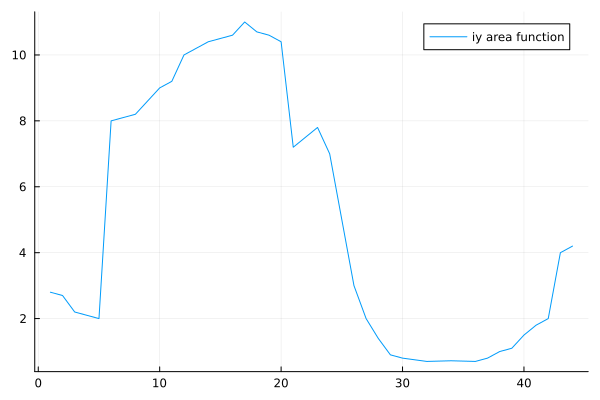

In [98]:
f, h, z, zrad = transmission_line_model(iy.a, fill(iy.l, length(iy.a)))

plot(iy.a, label="iy area function")

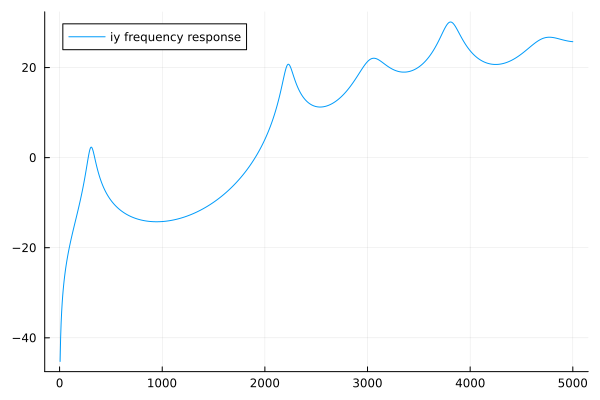

In [99]:
plot(f, 20 .* log10.(abs.(h)), label="iy frequency response")

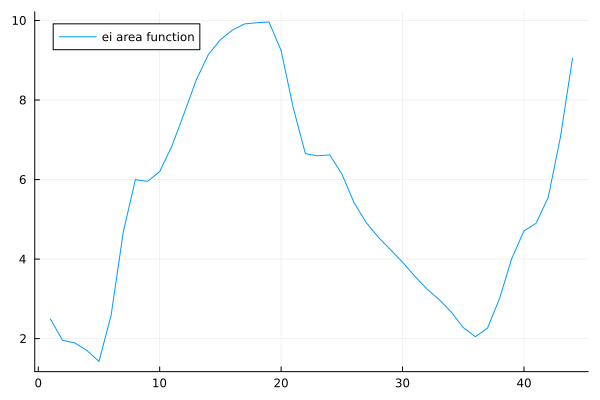

In [100]:
f, h, z, zrad = transmission_line_model(ei.a, fill(ei.l, length(ei.a)))

plot(ei.a, label="ei area function")

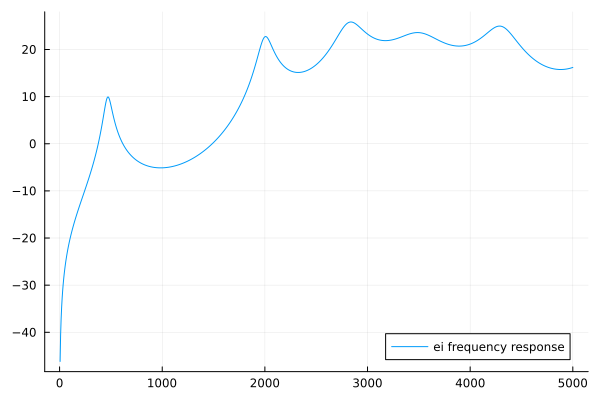

In [101]:
plot(f, 20 .* log10.(abs.(h)), label="ei frequency response")

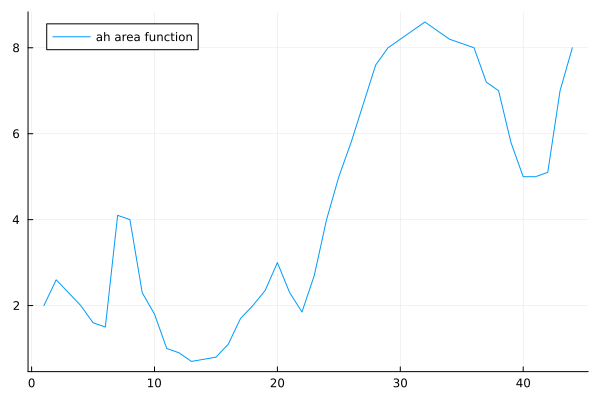

In [102]:
f, h, z, zrad = transmission_line_model(ah.a, fill(ah.l, length(ah.a)))

plot(ah.a, label="ah area function")

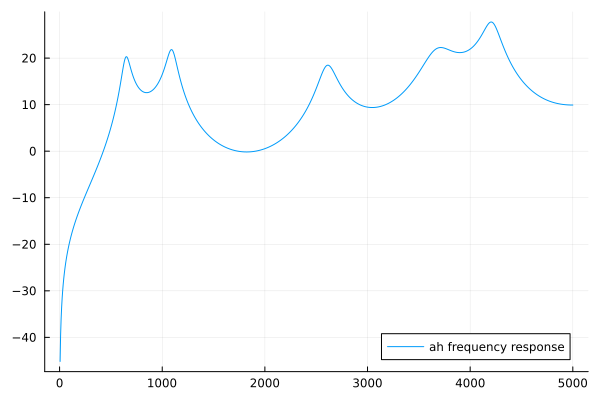

In [103]:
plot(f, 20 .* log10.(abs.(h)), label="ah frequency response")

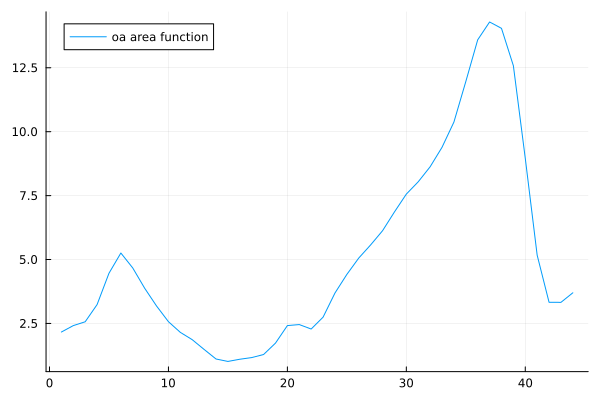

In [104]:
f, h, z, zrad = transmission_line_model(oa.a, fill(oa.l, length(oa.a)))

plot(oa.a, label="oa area function")

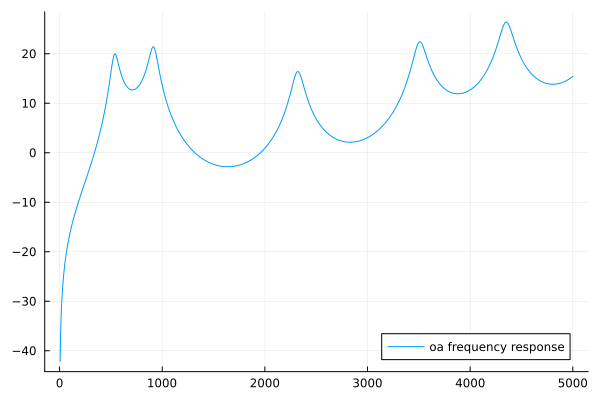

In [105]:
plot(f, 20 .* log10.(abs.(h)), label="oa frequency response")

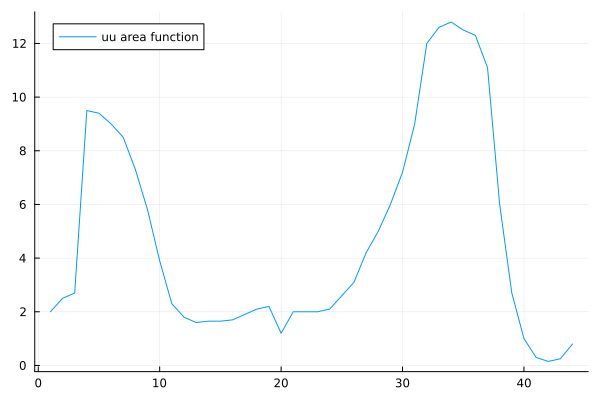

In [106]:
f, h, z, zrad = transmission_line_model(uu.a, fill(uu.l, length(uu.a)))

plot(uu.a, label="uu area function")

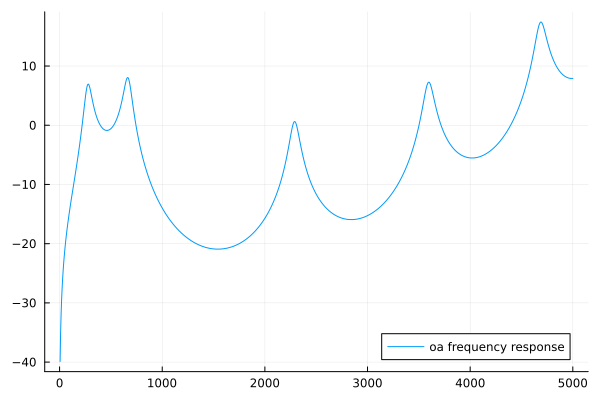

In [107]:
plot(f, 20 .* log10.(abs.(h)), label="oa frequency response")

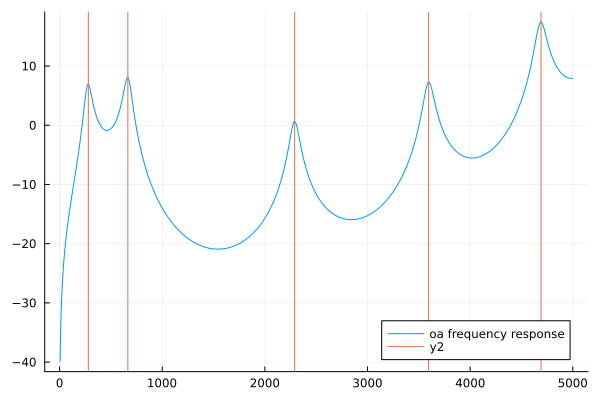

In [108]:
# Resonance peak picking test
peaks, peak_indices = find_peaks(x=f, y=20 .* log10.(abs.(h)))
vline!(peaks)

In [122]:
l = 17.6
a = 16 # 5 or so
# ar = 8.0
# lr = 8.0
b_a = (8/9)*a
b_l = (8/9)*l
f_a = (1/9)*a
f_l = (1/9)*l
f, h, _, _ = transmission_line_model([b_a, f_a], [b_l, f_l])

([5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0  …  4955.0, 4960.0, 4965.0, 4970.0, 4975.0, 4980.0, 4985.0, 4990.0, 4995.0, 5000.0], ComplexF64[0.0018597497122305024 + 0.009303359854907642im; 0.0023804202410532146 + 0.017326192349572524im; … ; -0.6898156263037133 - 1.4840460177454764im; -0.6968553350336906 - 1.485595625623077im;;], ComplexF64[0.8138266967909032 - 0.04430406677411123im; 0.7766319473884216 + 0.06126542030597432im; … ; 0.5026282506336646 + 0.07583744036116663im; 0.5037014092886914 + 0.11499703657828228im;;], ComplexF64[5.1163072264705296e-6 + 0.0128635204699405im; 2.0465219193379855e-5 + 0.025727028730198685im; … ; 4.409856544244577 + 11.098446687407431im; 4.417483030383921 + 11.106522902487715im;;])

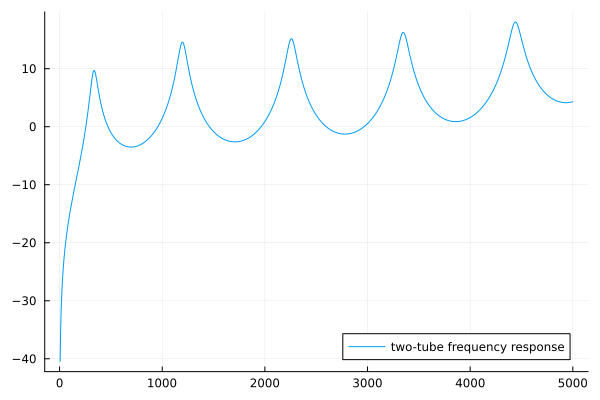

In [123]:
plot(f, 20 .* log10.(abs.(h)), label="two-tube frequency response")

In [124]:
# Expect [320, 1200, 2300, 3430] based on book page 66
peaks, _ = find_peaks(x=f, y=20 .* log10.(abs.(h)))

(Any[335.0, 1195.0, 2260.0, 3350.0, 4440.0], Any[67, 239, 452, 670, 888])

6

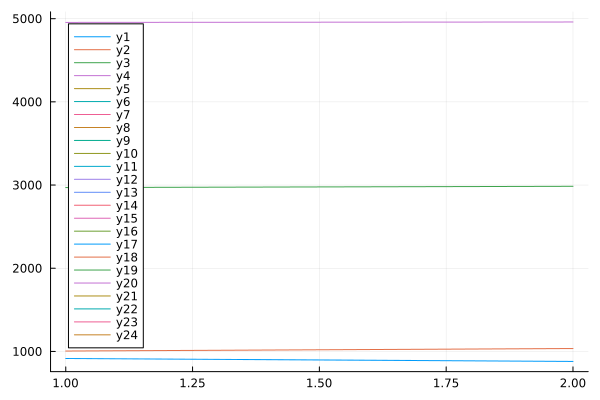

In [125]:
# Attempting to make a nomogram figure like book page 65
ars = [1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]
lrs = [1, 1.2, 1.5, 3, 5, 8]
l = 17.6
a = 5
skipped = 0
formant_set = []
for j in 1:length(lrs)
    f1s = []
    f2s = []
    f3s = []
    f4s = []
    b_lr = lrs[j]/(lrs[j] + 1/lrs[j])
    f_lr = 1/lrs[j]/(lrs[j] + 1/lrs[j])
    b_l = b_lr*l
    f_l = f_lr*l
    for i in 1:length(ars)
        b_ar = ars[i]/(ars[i] + 1/ars[i])
        f_ar = 1/ars[i]/(ars[i] + 1/ars[i])
        b_a = b_ar*a
        f_a = f_ar*a
        f, h, _, _ = transmission_line_model([b_a, f_a], [b_l, f_l])
        peaks, _ = find_peaks(x=f, y=20 .* log10.(abs.(h)), interpolation=false, amp_min=-200)
        # println(peaks)
        if length(peaks)==4
            push!(f1s, peaks[1])
            push!(f2s, peaks[2])
            push!(f3s, peaks[3])
            push!(f4s, peaks[4])
        else
            skipped += 1
        end
    end
    push!(formant_set, [f1s, f2s, f3s, f4s])
end
print(length(formant_set))
plot(formant_set[1][1])
plot!(formant_set[1][2])
plot!(formant_set[1][3])
plot!(formant_set[1][4])
plot!(formant_set[2][1])
plot!(formant_set[2][2])
plot!(formant_set[2][3])
plot!(formant_set[2][4])
plot!(formant_set[3][1])
plot!(formant_set[3][2])
plot!(formant_set[3][3])
plot!(formant_set[3][4])
plot!(formant_set[4][1])
plot!(formant_set[4][2])
plot!(formant_set[4][3])
plot!(formant_set[4][4])
plot!(formant_set[5][1])
plot!(formant_set[5][2])
plot!(formant_set[5][3])
plot!(formant_set[5][4])
plot!(formant_set[6][1])
plot!(formant_set[6][2])
plot!(formant_set[6][3])
plot!(formant_set[6][4])

In [ ]:
# Let's try that again


In [ ]:
# Fant's 3-parameter model from page 74

"""
- tongue location: length of constriction tubelet
  * this approximates location of tongue constriction by accounting for total length and length of tubelets on either side
- tongue area: area of constriction tubelet
- mouth ratio: the length of the lips tubelet over the area of the lips tubelet
  * the length of the lips tubelet is always 1 or 0. If 0, total length is decreased from 16 to 15cm.
"""
function p3_model(
    tongue_location::Float64=5.0,
    tongue_area::Float64=0.65,
    mouth_ratio::Float64=0.5,
)

    area_function = []
    length_function = []

    # Fixed(ish) parameters
    total_length = 15.0
    scale_excess = 2.5
    scale_max = total_length + scale_excess
    max_tubelet_length = total_length / 3
    a2 = 8.0
    a4 = 8.0

    # Lips tubelet
    if mouth_ratio > 0
        push!(area_function, inv(mouth_ratio))
        push!(length_function, 1.0)
    end

    # Remaining tubelet lengths
    l2 = 0.0
    l3 = 0.0
    l4 = tongue_location - scale_excess
    if l4 < 0.0
        l4 = 0.0
    end
    rem = total_length - l4
    if rem >= max_tubelet_length && l4 == 0.0
        l3 = (scale_max + tongue_location) - total_length
        l2 = total_length - l3
    elseif rem >= max_tubelet_length && l4 != 0.0
        l3 = max_tubelet_length
        l2 = total_length - (l3 + l4)
    elseif rem < max_tubelet_length
        l3 = rem
    end

    # Cleanup
    push!(length_function, l2)
    push!(area_function, a2)
    push!(length_function, l3)
    push!(area_function, tongue_area)
    push!(length_function, l4)
    push!(area_function, a4)
    l = []
    a = []
    for i in 1:length(length_function)
        if length_function[i] > 0.0
            push!(l, length_function[i])
            push!(a, area_function[i])
        end
    end

    return a, l
end

p3_model

In [82]:
println(p3_model(-2.5))

1.0 2.0
15.0 8.0
0.0 0.65
0.0 8.0
(Any[2.0, 8.0], Any[1.0, 15.0])
